# Introducción

Se ha recibido una tarea analítica de una tienda en línea internacional. no se ha conseguido completarla: se lanzó una prueba A/B y luego se abandonó (para iniciar una granja de sandías en Brasil). Solo se dejaron las especificaciones técnicas y los resultados de las pruebas.

__Descripción técnica:__
- __Nombre de la prueba:__ recommender_system_test
- __Grupos:__ А (control), B (nuevo embudo de pago)
- __Fecha de lanzamiento:__ 2020-12-07
- __Fecha en la que dejaron de aceptar nuevos usuarios:__ 2020-12-21
- __Fecha de finalización:__ 2021-01-01
- __Audiencia:__ 15% de los nuevos usuarios de la región de la UE
- __Propósito de la prueba:__ probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- __Resultado esperado:__ dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). En cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.
- __Número previsto de participantes de la prueba:__ 6 000

# Descripción de los datos

Se proporcionan cuatro datasets dara desarrollar las pruebas.

`ab_project__marketing_events_us.csv`, el calendario de eventos de marketing para 2020.
- `name` — el nombre del evento de marketing
- `regions` — regiones donde se llevará a cabo la campaña publicitaria
- `start_dt` — fecha de inicio de la campaña
- `finish_dt` — fecha de finalización de la campaña

`final_ab_new_users_upd_us.csv`,  todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020.
- `user_id`
- `first_date` — fecha de inscripción
- `region`
- `device` — dispositivo utilizado para la inscripción

`final_ab_events_upd_us.csv`,  todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021:
- `user_id`
- `event_dt` — fecha y hora del evento
- `event_name` — nombre del tipo de evento
- `details` — datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase)

`final_ab_participants_upd_us.csv`, tabla con los datos de los participantes de la prueba:
- `user_id`
- `ab_test` — nombre de la prueba
- `group` — el grupo de prueba al que pertenecía el usuario

# Pauta de trabajo

Este informe estará dividido en cuatro partes, cada una de ellas tendrá diferentos objetivos:

__Preanálisis:__ Etapa en la cual se cargan los datos y se optimizan en caso de ser necesario, se trabajan los valores duplicados y ausentes, y finalmente, se modifican los datos para facilitar el posterior análisis.
Describe los objetivos del estudio.
- ¿Es necesario convertir los tipos?
- ¿Hay valores ausentes o duplicados? Si es así, ¿cómo se caracterizarían?

__Análisis exploratorio de datos:__ En esta fase se estudiarán las diferentes variables y la calidad de los datos para el desarrollo de una prueba A/B.
- Estudiar la conversión en las diferentes etapas del embudo.
- ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
- ¿Hay usuarios que están presentes en ambas muestras?
- ¿Cómo se distribuye el número de eventos entre los días?
- ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

__Evaluar los resultados de la prueba A/B:__ Una vez determinada la calidad de los datos, se realizan las pruebas estadísticas para determinar si se cumplen los objetivos.
- Utilizar una prueba z para comprobar la diferencia estadística entre las proporciones.
- ¿Qué se puede concluir sobre los resultados de la prueba A/B?

__Conclusiones:__ Se presentarán las conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B.

## Preanálisis

Se da inicio al proyecto.

### Importación de librerías

Se importan todas las librerías necesarias para el análisis, pruebas estadísticas y visualizaciones de datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st 
import math as mt
import datetime as dt
from plotly import graph_objects as go

### Carga de datos

Una vez importadas las librerías, se cargan los datasets proporcionados cuidando la optimización de espacio para trabajar de manera más fluída.

In [2]:
pm_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', parse_dates=['start_dt', 'finish_dt'])
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv', parse_dates=['first_date'], dtype={'region' : 'category', 'device' : 'category'})
ab_events = pd.read_csv('/datasets/final_ab_events_upd_us.csv', parse_dates=['event_dt'], dtype={'event_name' : 'category'})
ab_participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

### Previsualización de datos

Se le dará una primera revisión la los datos, para observar que los tipos de datos estén correctos y si es que hay valores ausentes.

In [3]:
pm_events.info()
pm_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


En `pm_events` no se observa nada fuera de lugar, continuamos con el siguiente dataset.

In [4]:
new_users.info()
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  category      
 3   device      58703 non-null  category      
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 1.0+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


En `new_users` tampoco se observan tipos de datos erróneos ni valores ausentes, continuamos con el siguiente conjunto de datos.

In [5]:
ab_events.info()
ab_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  category      
 3   details     60314 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(1)
memory usage: 10.1+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


En este dataset se observa una gran cantidad de valores ausentes en la columna `details`, debido a que son muchos y a que es una columna de la cual se puede prescindir para un análisis de proporciones, es que no se trabajarán estos valores ausentes. Seguimos con el último dataset.

In [6]:
ab_participants.info()
ab_participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


`ab_participants` no cuenta con ningún problema visible, es cierto que podría ser optimizado, pero al ser de tamaño tan reducido, no es necesario hacerlo.

### Trabajar valores duplicados

En esta etapa se buscarán duplicados en todos los datasets y se trabajarán de la mejor manera posible.

In [7]:
print(pm_events.duplicated().sum())
print(new_users.duplicated().sum())
print(ab_events.duplicated().sum())
print(ab_participants.duplicated().sum())

0
0
0
0


No se encuentran duplicados explícitos, ahora se buscarán implícitos.

In [8]:
print(new_users['region'].value_counts())
print()
print(new_users['device'].value_counts())

EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: region, dtype: int64

Android    26159
PC         14845
iPhone     11902
Mac         5797
Name: device, dtype: int64


No se encuentran duplicados implícitos en `new_users`.

In [9]:
ab_events['event_name'].value_counts()

login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64

Tampoco se encuentran en `ab_events`.

## Análisis exploratorio de datos

En esta etapa se analizará principalmente la conversión a través de las etapas del embudo y la integridad de los datos conforme al test A/B.

### Estudiar la conversión en las diferentes etapas del embudo

Para comenzar a estudiar el embudo, primero debemos extraer los datos pertenecientes a nuestra prueba de interés. Primero agregamos toda la información en un solo dataset, para posteriormente filtrarla.

In [10]:
events = ab_events.merge(ab_participants, on='user_id')
events = events.merge(new_users, on='user_id')
events.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,B,interface_eu_test,2020-12-07,EU,iPhone
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,B,interface_eu_test,2020-12-07,EU,iPhone


Una vez tenemos toda la información reunida, procedemos a filtrar por:
- __Nombre de prueba:__ `recommender_system_test`.
- __Región:__ `EU`.
- __Días desde el registro:__ `14`.

Que son los datos relevantes para el desarrollo de la prueba.

In [11]:
events = events[(events['ab_test'] == 'recommender_system_test') & (events['region'] == 'EU')]
events['days_since_reg'] = (events['event_dt'] - events['first_date']).dt.days
events = events[events['days_since_reg'] <= 14]
events.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,days_since_reg
12,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,0
13,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test,2020-12-07,EU,Android,2
14,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,0
15,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,1
16,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,2


Una vez filtrado el dataset, podemos desglosar el embudo.

In [12]:
funnel = events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
funnel

,event_name,user_id
0,login,3480
1,product_page,2178
2,purchase,1082
3,product_cart,1026


Usando estos datos, construiremos una visualización que nos permita analizar de mejor manera el embudo. Si observamos bien, nos daremos cuenta que por el evento `product_cart` han pasado menos clientes que por el evento `purchase`, esto quiere decir que en esta web __el carrito de producto es algo opcional y se puede comprar sin pasar por él__.

In [13]:
fig = go.Figure(go.Funnel(
    meta = funnel,
    y = funnel['event_name'],
    x = funnel['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"
    ))

plt.close()

(Se adjunta una foto debido a que la librería `Figure` de gráficos interactivos, necesita tener el kernel funcionando para mostrar la visualización, debido a eso, una imagen adjunta es más práctico.)

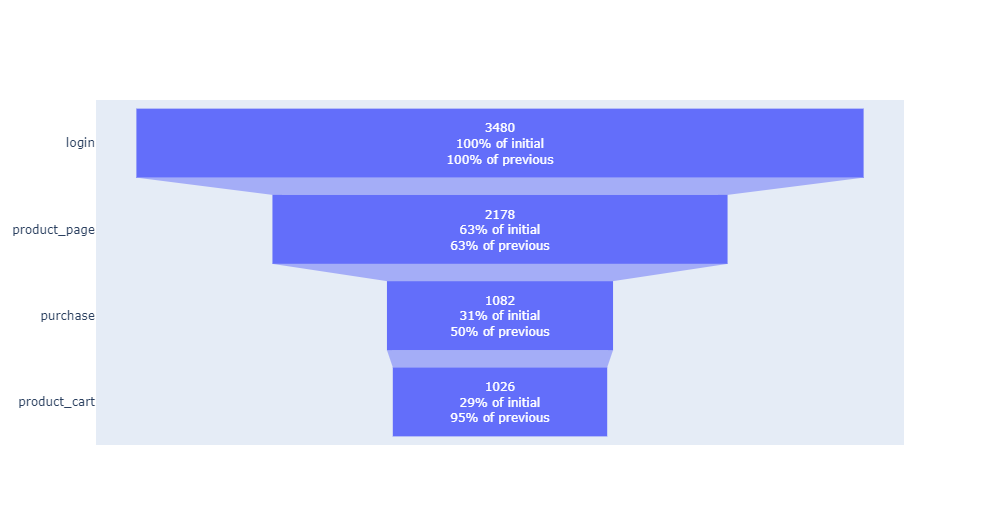

En en embudo se puede observar que en la etapa donde más se pierden clientes es en __la transición de página de producto a la compra__ (un 50%). Ahora, trazaremos el mismo gráfico de embudo, pero dividido por grupos, para lo cual, primero, debemos crear un dataset con la información general de cada grupo.

In [14]:
A = events[events['group'] == 'A'].groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
B = events[events['group'] == 'B'].groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()

Una vez listos los datasets, podemos construir el gráfico.

In [15]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    meta = A,
    y = A['event_name'],
    x = A['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"
    ))

fig.add_trace(go.Funnel(
    name = 'B',
    meta = B,
    y = B['event_name'],
    x = B['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous+percent initial"
    ))

plt.close()

(Se adjunta una foto debido a que la librería `Figure` de gráficos interactivos, necesita tener el kernel funcionando para mostrar la visualización, debido a eso, una imagen adjunta es más práctico.)

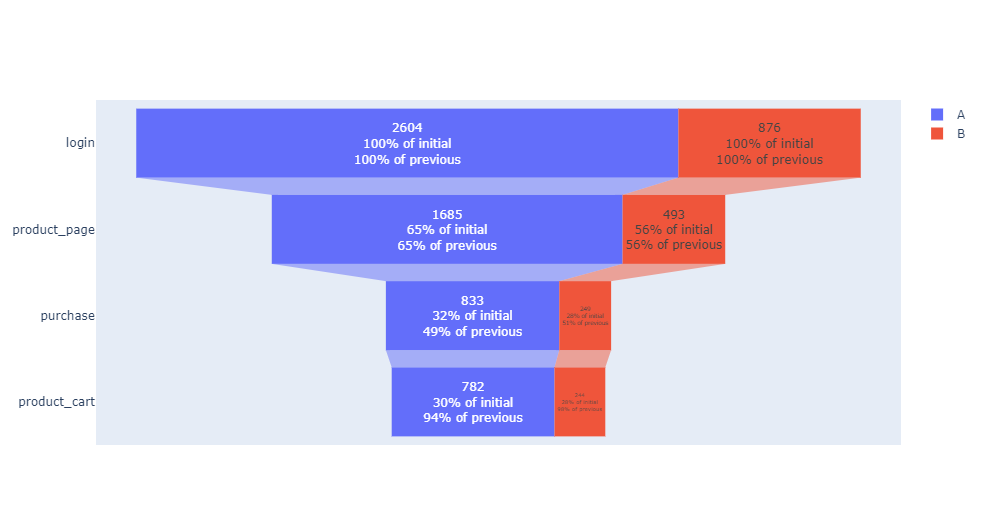

Respecto del gráfico, __se puede evidenciar una gran diferencia en la cantidad de usuarios registrados por grupo__, esto puede influir en los porcentajes de conversión de cada etapa, inclinando la balanza hacia el grupo con más registros, se especificarán mas adelante los valores exactos.

### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

Se calculará el número de eventos por usuario junto con otros datos que permiten verificar la calidad de los datos para un test A/B.

In [16]:
print('Eventos por usuario grupo A:', format(events[events['group'] == 'A'].groupby('user_id')['event_name'].count().mean(), '.2f'))
print('Eventos por usuario grupo B:', format(events[events['group'] == 'B'].groupby('user_id')['event_name'].count().mean(), '.2f'))

Eventos por usuario grupo A: 6.67
Eventos por usuario grupo B: 5.45


__El número de eventos por usuario es similar__. Si el número de participantes por grupo es similar, la prueba aún podría dar resultados fiables, por lo que se seguirá indagando en los datos.

In [17]:
print('Total participantes registrados:', events['user_id'].nunique())

Total participantes registrados: 3481


Se registran 3481 participantes que es __un poco más de la mitad__ de los participantes previstos (6000). Se analizará ahora el número de eventos por grupo.

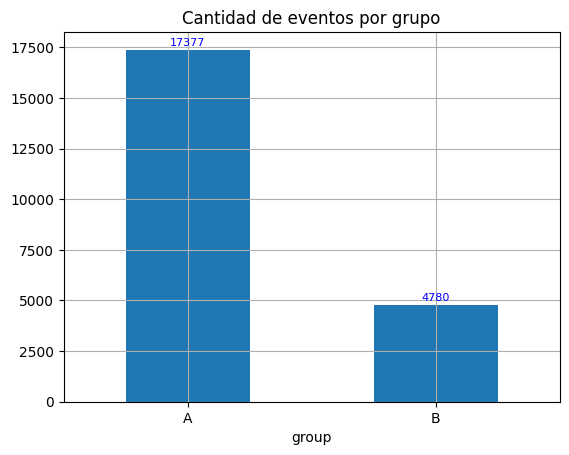

In [18]:
ax = events.groupby('group')['user_id'].count().plot(kind='bar', rot=0, title='Cantidad de eventos por grupo', grid='on');
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8, color='blue');

__Tenemos 3.64 veces más eventos en el grupo A que en el grupo B__, una diferecia así indica que los grupos están desbalanceados y que esto puede afectar la interpretación del experimento.

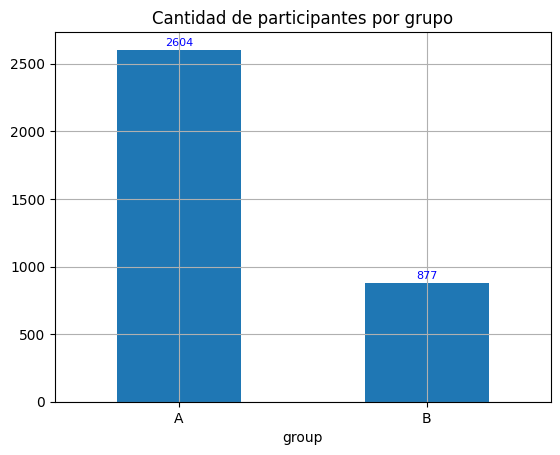

In [19]:
ax = events.groupby('group')['user_id'].nunique().plot(kind='bar', rot=0, title='Cantidad de participantes por grupo', grid='on');
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8, color='blue');

__La diferencia de participantes por grupo es muy grande, la cantidad de participantes del grupo A es 2.97 veces más grande que en el grupo B__, esto constituye un problema para el desarrollo de la prueba, ya que los resultados podrían inclinarse en favor del grupo que tiene más participantes y los resultados podrían ser inválidos.

### ¿Hay usuarios que están presentes en ambas muestras?

Mediante una prueba simple se determinará si hay o no, usuarios presentes en ambos grupos.

In [20]:
len(pd.Series(list(set(events[events['group'] == 'A']['user_id']) &
                   set(events[events['group'] == 'B']['user_id'])), dtype='float64'))

0

__No se detectan usuarios en ambos grupos__, lo que indica que no se cometieron errores de clasificación en los grupos.

### ¿Cómo se distribuye el número de eventos entre los días?

Para observar como se distribuyen los eventos entre los días se creará un gráfico de barras con su respectivo número de eventos por cada día registrado.

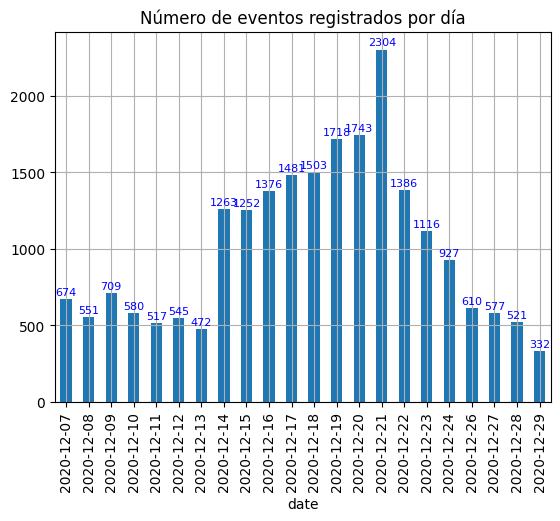

In [21]:
events['date'] = events['event_dt'].dt.date
ax = events.groupby('date')['event_name'].count().plot(kind='bar', rot=90, grid='on', title='Número de eventos registrados por día');
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8, color='blue');

Se observa que __la distribución no es pareja__, hay días con más de 1.500 eventos y días con menos de 500. La fecha seleccionada para recopilar los datos es navidad, lo cual provoca estas disparidades entre los días, al probar un nuevo sistema recomendador que funcionará todo el año, __lo mejor evitar fechas como navidad o algún evento parecido, resultaría más conveniente elegir un rango de fechas donde exista un buen flujo de clientes sin mucha variación entre los días__.

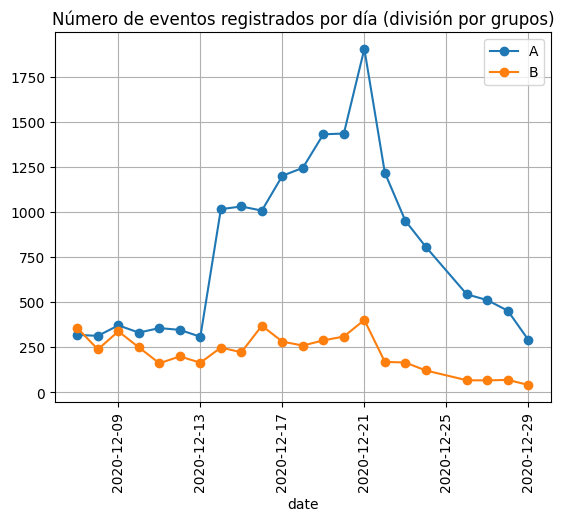

In [22]:
ax = events[events['group'] == 'A'].groupby('date')['event_name'].count().plot(rot=90, grid='on', style='-o')
events[events['group'] == 'B'].groupby('date')['event_name'].count().plot(rot=90, grid='on', style='-o')
plt.title('Número de eventos registrados por día (división por grupos)')
plt.legend(['A', 'B']);

El gráfico ilustra que __hay diferencias en cuanto a la cantidad de datos de cada grupo recolectados por fecha__, mientras el grupo B se mantiene relativamente parejo a lo largo del estudio, el grupo A se dispara después del 12 de diciembre para decaer post navidad.

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Recapitulando el análisis exploratorio, se encontraron los siguientes puntos a tener en cuenta sobre la calidad de los datos para el test A/B.
- __La cantidad de usuarios del grupo A es casi tres veces más grande que la del grupo B__, esto puede inclinar los resultados de la prueba hacia el grupo A.
- __La fecha elegida para la recolección de datos no es apropiada__, la fecha elegida para la recopilación de datos es fines de diciembre (incluyendo navidad) y en las instrucciones de la prueba no se menciona que la prueba tenga relación alguna con esta fecha, por lo cual (y por los motivos explicados en el bloque anterior) los resultados podrían verse afectados por el comportamiento "navideño" de los usuarios (que no es el mismo que durante el resto del año).
- __Disparidad en el tiempo__, probablemente debido a la fecha de recolección escogida, existen disparidades en la cantidad de datos registrados por día, entre ambos grupos, esto empeora aún más las condiciones de la prueba por las razones explicadas anteriormente.

## Evaluar los resultados de la prueba A/B

Se procederán a evaluar, mediante una prueba estadística, las diferencias entre los grupos A y B.

### Utilizar una prueba z para comprobar la diferencia estadística entre las proporciones.

Para automatizar el proceso de realizar la prueba z en las etapas del embudo, se define la siguiente función, la cual tomará como argumento el nombre del evento a comparar y devolverá una serie de datos acerca de los grupos, los valores p y si se aprueba o rechaza la hipótesis nula. El valor alpha a utilizar será de 0.05 y se aplicará la corrección de Bonferroni para disminuir las probabilidades de error.

In [23]:
def prop_test(event):
    
    conversions = events[['user_id', 'group']].drop_duplicates()
    converted = pd.DataFrame(data={"user_id": events[events["event_name"] == event]["user_id"].unique(), "converted": 1})
    conversions = conversions.merge(converted, on="user_id", how="left")
    conversions["converted"] = conversions["converted"].fillna(0)
    
    purchases = np.array([len(conversions[(conversions['group'] == 'A') & (conversions['converted'] == 1)]), 
                          len(conversions[(conversions['group'] == 'B') & (conversions['converted'] == 1)])])
                          
    leads = np.array([len(conversions[conversions['group'] == 'A']), 
                      len(conversions[conversions['group'] == 'B'])])
    
    print(event, ':', purchases)
    print('Total :', leads)
    
    alpha = .05/3 #Corrección de Bonferroni
    
    p1 = purchases[0]/leads[0]
    p2 = purchases[1]/leads[1]
    p_combined = ((purchases[0] + purchases[1]) / (leads[0] + leads[1]))
    difference = p1 - p2
    
    print('A:', format(p1, '.2%'), '%  ', 'B:',format(p2, '.2%'), '%.')

    z_value = difference / mt.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
    else:
        print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

Una vez definida la función, solo queda comparar los diferentes eventos. empezando con 
- `product_page` La pantalla de producto.

In [24]:
prop_test('product_page')

product_page : [1685  493]
Total : [2604  877]
A: 64.71% %   B: 56.21% %.
p-value:  6.942739359416805e-06
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones


Aquí __se rechaza la hipótesis nula en favor del grupo A__, que __muestra un 8,5% más de conversión que el grupo B__.
- `product_cart` La pantalla de carrito de compras.

In [25]:
prop_test('product_cart')

product_cart : [782 244]
Total : [2604  877]
A: 30.03% %   B: 27.82% %.
p-value:  0.21469192029582396
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


No se rechaza la hipótesis nula, sin embargo __el grupo A se muestra un 2.21% por encima del grupo B__ en conversión.
- `purchase` Compra exitosa.

In [26]:
prop_test('purchase')

purchase : [833 249]
Total : [2604  877]
A: 31.99% %   B: 28.39% %.
p-value:  0.04652482738393027
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Aquí no se rechaza la hipótesis nula, sin embargo observando el valor p se puede apreciar que está muy cerca de rechazarse (si no se hubiese aplicado la corrección de Bonferroni, se habría rechazado). __El grupo A está un 3,6% arriba del grupo B__ en tasa de conversión.

### ¿Qué se puede concluir sobre los resultados de la prueba A/B?

En base al desarrollo de la prueba se puede concluir (dejando de lado las conclusiones sobre la calidad de los datos) que __se rechaza el grupo B, ya que el requisito de aprobación es superar en un 10% la conversión en todas las etapas y no se cumplió__ (ni estuvo cerca de hacerlo).

## Conclusiones

En este apartado se desarollarán ampliamente todas las conclusiones obtenidas en el desarrollo del informe, haciendo hincapié en los aspectos fundamentales del trabajo, como lo son: los hallazgos sobre el registro de los datos, recomendaciones para el futuro y la resolución final del experimento.

### Hallazgos sobre el registro de los datos

Se han encontrado problemas graves en cuanto al registro de los datos del experimento, tales como:

- __Fecha de recolección:__ La fecha elegida para la recopilación de datos es fines de diciembre (incluyendo navidad) y en las instrucciones de la prueba no se menciona que la prueba tenga relación alguna con esta fecha, por lo cual (y por los motivos explicados en el bloque anterior) los resultados podrían verse afectados por el comportamiento "navideño" de los usuarios (que no es el mismo que durante el resto del año).

- __Cantidad de usuarios por grupo:__ Se registran casi tres veces más usuarios en el grupo A que en el grupo B, este factor, por sí solo ya es suficiente para declarar la prueba como inválida, ya que al ser tan grande la diferencia entre los grupos, las proporciones pueden inclinarse seriamente en favor del grupo más grande (el grupo A).

- __Sostenibilidad en el tiempo:__ Relacionado con los puntos anteriores, se observó en estos registros que la cantidad de datos por grupo varía demasiado en el tiempo de recolección, lo cual empeora las condiciones de la prueba de acuerdo con los puntos explicados anteriormente.

### Recomendaciones para el futuro

Para evitar los problemas anteriormente mencionados, se deberían seguir los siguientes consejos:

- __Fecha de recolección:__ Se debe escoger una fecha de recolección donde el flujo sea lo más estándar posble, cuidando el que haya suficientes datos para analizar, un buen ejemplo sería analizar los meses buenos y malos del negocio y lanzar la prueba en cualquier semana de la temporada buena, o analizar la última semana del mes y si los datos son parejos y considerables, proceder a lanzar la prueba.

- __Cantidad de usuarios por grupo:__ Se debe configurar correctamente el embudo a nivel de anuncios (o cualquiera sea la manera que tengan los clientes de consumir en la tienda) para que la cantidad de usuarios por grupo sea lo más pareja posible, cuidando que los datos recolectados sean suficientes para ser analizados.

- __Sostenibilidad en el tiempo:__ En línea con los puntos anteriores, la configuración adecuada debe mantenerse por una cantidad considerable de días (dependiendo de las necesidades del experimento).

### Resolución final del experimento

Una vez terminado el proyecto podemos rescatar lo siguiente:

- __Resultados del test:__ Al analizar los resultados (ignorando la mala calidad de los datos), estos indican que el grupo B debe ser rechazado, ya que no se cumplen los criterios de aprobación del grupo, que son superar en un 10% la tasa de conversión del grupo A.

Sin embargo, debido las malas condiciones de los datos recogidos para la prueba es que debemos concluir que:

__los resultados obtenidos de esta prueba no pueden ser utilizados para la toma de decisiones de la empresa, ya que de ser usados, pueden suponer un grave perjuicio para la organización__.